<a href="https://colab.research.google.com/github/sromanov103/Gradio_breed/blob/main/Gradio_predict_breed_%D0%94%D0%97_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Модель сети

In [ ]:
import keras
print(keras.__version__)

3.0.0


In [ ]:
!pip install --upgrade keras==3.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetB0

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2024-06-08 09:58:04--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  23.6MB/s    in 33s     

2024-06-08 09:58:38 (22.6 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
# Разархивируем датасета во временную папку 'temp'
!unzip -qo "stanford_dogs" -d ./dataset

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset/'

In [ ]:
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


In [ ]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.


In [ ]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

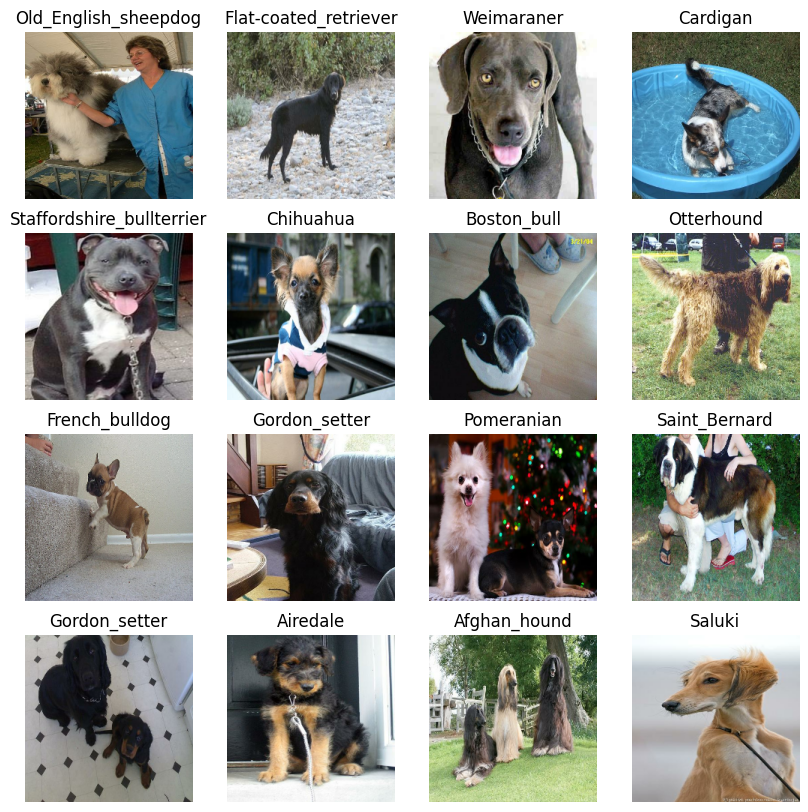

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # берем первый батч обучающей выборки
    for i in range(16): # отрисуем первые 16 картинок батча
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]]) # покажем метки
        plt.axis("off") # отключаем отображение осей

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

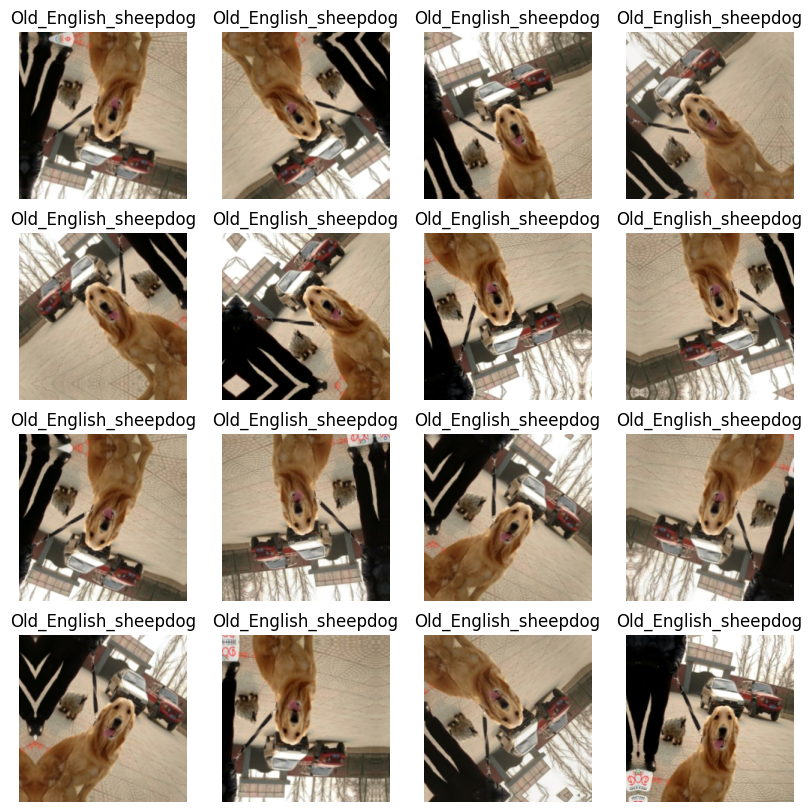

In [ ]:
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(16):
        augmented_images = img_augmentation(images[0])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8")) # Преобразуем картинку в тензор, теперь уже без NumPy
        plt.title("{}".format(CLASS_LIST[labels[0]])) # Вывод метки
        plt.axis("off")

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = keras.applications.EfficientNetV2S(
        include_top=False, input_tensor=inputs, weights="imagenet"
    )

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNetV2")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

In [ ]:
epochs = 7

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/7
 11/129 ━━━━━━━━━━━━━━━━━━━━ 57:01 29s/step - acc: 0.2305 - loss: 4.3754

KeyboardInterrupt: 

In [ ]:
show_plot(history)

In [ ]:
from google.colab import files
files.download('best_model_pretrain.keras')

In [ ]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 4
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
TEST_IMG='./Cardigan.jpeg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Cardigan \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

In [ ]:
# Оценка точности модели на проверочной выборке
loss, accuracy = model.evaluate(val_ds, verbose=0)
print(f"Точность модели на проверочной выборке: {accuracy * 100:.2f}%")

#FastAPI


In [ ]:
!pip install --upgrade keras==3.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [ ]:
import keras
print(keras.__version__)

3.0.0


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
!pip install fastapi # Установим FastAPI
!pip install uvicorn # Установим ASGI-сервер
!pip install python-multipart # Необходимая зависимость для FastAPI (для работы с данными отправленных форм на сайте)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install gdown

In [ ]:
import gdown
#Загрузка модели
url = 'https://drive.google.com/file/d/1ja1nDnxKdRZmWmScl_EYhuW8GesJYVSW/view?usp=sharing'
file_id = url.split('/')[-2]
gdown.download(id=file_id, quiet=False, output='best_model_pretrain.keras')

Downloading...
From (original): https://drive.google.com/uc?id=1ja1nDnxKdRZmWmScl_EYhuW8GesJYVSW
From (redirected): https://drive.google.com/uc?id=1ja1nDnxKdRZmWmScl_EYhuW8GesJYVSW&confirm=t&uuid=4e4f6d4b-0387-4093-82a1-3dfc56033a30
To: /content/best_model_pretrain.keras
100%|██████████| 84.9M/84.9M [00:02<00:00, 30.6MB/s]


'best_model_pretrain.keras'

In [ ]:
%%writefile main.py
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

# Загрузка модели
model = tf.keras.models.load_model('best_model_pretrain.keras')

# Создание приложения
st.title("Сервис классификации пород собак")

# Функция предсказания
def predict(image):
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_names = class_names = ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier',
                   'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer',
                   'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie',
                   'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever',
                   'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog',
                   'Groenendael', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Keeshond', 'Kelpie', 'Kerry_blue_terrier',
                   'Komondor', 'Kuvasz', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Malamute', 'Malinois', 'Maltese_dog', 'Mexican_hairless', 'Miniature_pinscher', 'Miniature_poodle',
                   'Miniature_schnauzer', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Otterhound', 'Papillon', 'Pekinese', 'Pembroke', 'Pomeranian',
                   'Pug', 'Redbone', 'Rhodesian_ridgeback', 'Rottweiler', 'Saint_Bernard', 'Saluki', 'Samoyed', 'Schipperke', 'Scotch_terrier', 'Scottish_deerhound', 'Sealyham_terrier', 'Shetland_sheepdog',
                   'Shih-Tzu', 'Siberian_husky', 'Silky_terrier', 'Soft-coated_wheaten_terrier', 'Staffordshire_bullterrier', 'Standard_poodle', 'Standard_schnauzer', 'Sussex_spaniel', 'Tibetan_mastiff',
                   'Tibetan_terrier', 'Toy_poodle', 'Toy_terrier', 'Vizsla', 'Walker_hound', 'Weimaraner', 'Welsh_springer_spaniel', 'West_Highland_white_terrier', 'Whippet', 'Wire-haired_fox_terrier', 'Yorkshire_terrier']
    return {'class': class_names[predicted_class], 'confidence': float(prediction[0][predicted_class])}

# Интерфейс приложения
file_uploader = st.file_uploader("Выберите файл изображения", type=["jpg", "png"])
if file_uploader is not None:
    image = Image.open(file_uploader)
    st.image(image, use_column_width=True)
    result = predict(image)
    st.write("Класс:", result['class'])
    st.write("Точность предсказания:", result['confidence'])

Writing main.py


In [ ]:
!streamlit run main.py --server.address=localhost >/content/logs.txt & ssh -o "StrictHostKeyChecking no" -R 80:localhost:8501 serveo.net

Forwarding HTTP traffic from https://bf00eca982f56f66b14573b6ade880d4.serveo.net
HTTP request from 188.162.5.178 to https://bf00eca982f56f66b14573b6ade880d4.serveo.net/
HTTP request from 188.162.5.178 to https://bf00eca982f56f66b14573b6ade880d4.serveo.net/static/media/SourceSansPro-Regular.0d69e5ff5e92ac64a0c9.woff2
HTTP request from 188.162.5.178 to https://bf00eca982f56f66b14573b6ade880d4.serveo.net/static/media/SourceSansPro-Bold.118dea98980e20a81ced.woff2
HTTP request from 188.162.5.178 to https://bf00eca982f56f66b14573b6ade880d4.serveo.net/static/css/main.3aaaea00.css
HTTP request from 188.162.5.178 to https://bf00eca982f56f66b14573b6ade880d4.serveo.net/static/media/SourceSansPro-SemiBold.abed79cd0df1827e18cf.woff2
HTTP request from 188.162.5.178 to https://bf00eca982f56f66b14573b6ade880d4.serveo.net/static/js/main.7994a814.js
HTTP request from 188.162.5.178 to https://bf00eca982f56f66b14573b6ade880d4.serveo.net/_stcore/health
HTTP request from 188.162.5.178 to https://bf00eca982f

In [ ]:
#Фото для проверки
import gdown

url = 'https://drive.google.com/file/d/1p18fH-DgabmVX5aOhRqZVYUfqX2I3A1v/view?usp=sharing'
file_id = url.split('/')[-2]
gdown.download(id=file_id, quiet=False, output='./Cardigan.jpeg')

Downloading...
From: https://drive.google.com/uc?id=1p18fH-DgabmVX5aOhRqZVYUfqX2I3A1v
To: /content/Cardigan.jpeg
100%|██████████| 47.3k/47.3k [00:00<00:00, 62.0MB/s]


'./Cardigan.jpeg'